In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


2025-05-29 18:04:40.992134: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-29 18:04:40.992312: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-29 18:04:40.992316: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-29 18:04:40.992329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-29 18:04:40.992339: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [6]:
len(dataset)

78

2025-05-29 18:05:11.155383: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


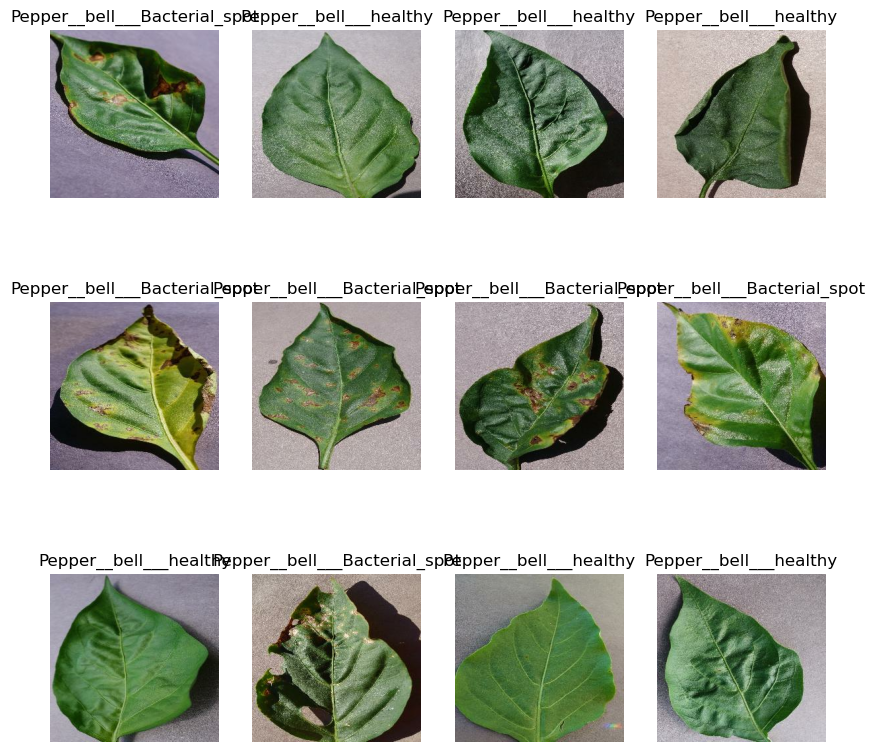

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [8]:
len(dataset)

78

In [9]:
train_size=0.8
len(dataset)*train_size

62.400000000000006

In [18]:
train_ds = dataset.take(62)
len(train_ds)

62

In [34]:
test_ds = dataset.skip(62)
len(test_ds)

16

In [35]:
val_size = 0.1
len(dataset)*val_size

7.800000000000001

In [36]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [37]:
test_ds = test_ds.skip(7)
len(test_ds)

9

In [29]:
def get_dataset_partitions_tf(ds,train_split = 0.8 ,val_split = 0.1,test_split = 0.1 , shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [30]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [31]:
len(train_ds)

62

In [32]:
len(val_ds)

7

In [38]:
len(test_ds)

9

In [39]:
train_ds=train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [41]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [65]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [66]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 32)         │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 2)                │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,522 (216.88 KB)

 Trainable params: 55,522 (216.88 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [68]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.5988 - loss: 0.6679 - val_accuracy: 0.7857 - val_loss: 0.5426
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7955 - loss: 0.4424 - val_accuracy: 0.9286 - val_loss: 0.3392
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.9262 - loss: 0.2060 - val_accuracy: 0.9732 - val_loss: 0.4212
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9589 - loss: 0.2154 - val_accuracy: 0.9554 - val_loss: 0.3714
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9606 - loss: 0.1382 - val_accuracy: 0.9821 - val_loss: 0.2564
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9832 - loss: 0.0761 - val_accuracy: 0.9866 - val_loss: 0.2846
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9798 - loss: 0.0670 - val_accuracy: 0.9911 - val_loss: 0.2108
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9888 - loss: 0.0457 - val_accuracy: 0

In [69]:
scores = model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9871 - loss: 0.0201


In [70]:
scores

[0.022572455927729607, 0.9887640476226807]

In [71]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

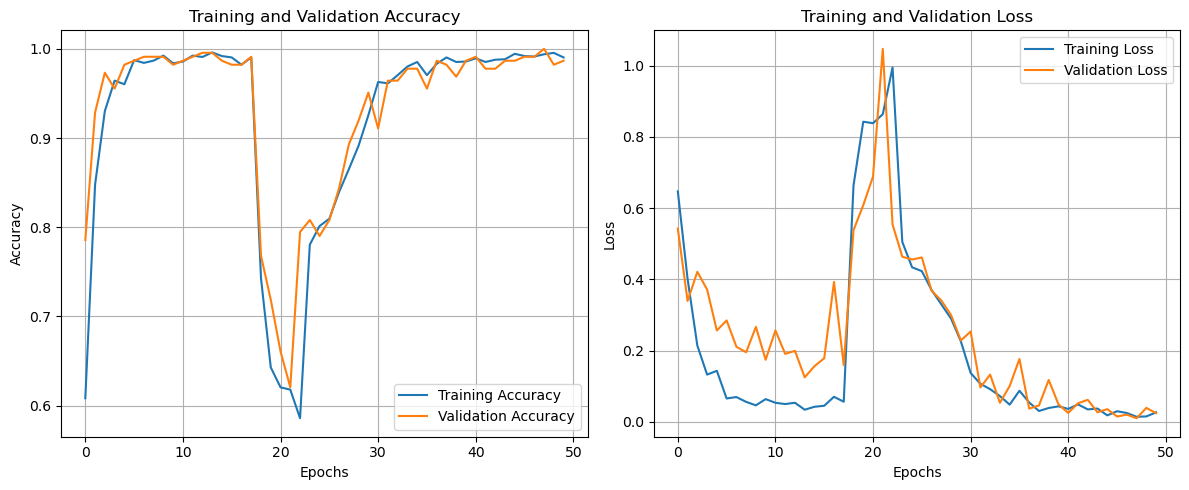

In [73]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [75]:
np.argmax([1.0000000e+00, 1.7232350e-10, 5.4814204e-19])

0

first Image to predict
actual Image: Pepper__bell___Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
predicted Label: Pepper__bell___Bacterial_spot


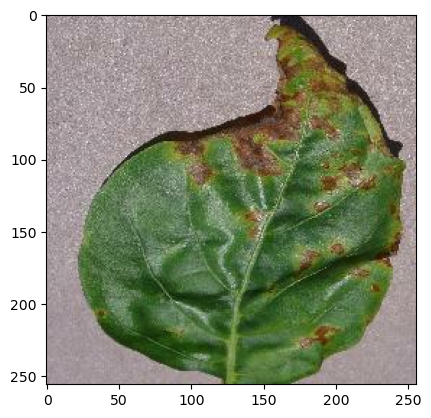

In [74]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    print("first Image to predict")
    plt.imshow(first_image)
    print("actual Image:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [76]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class , confidence
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

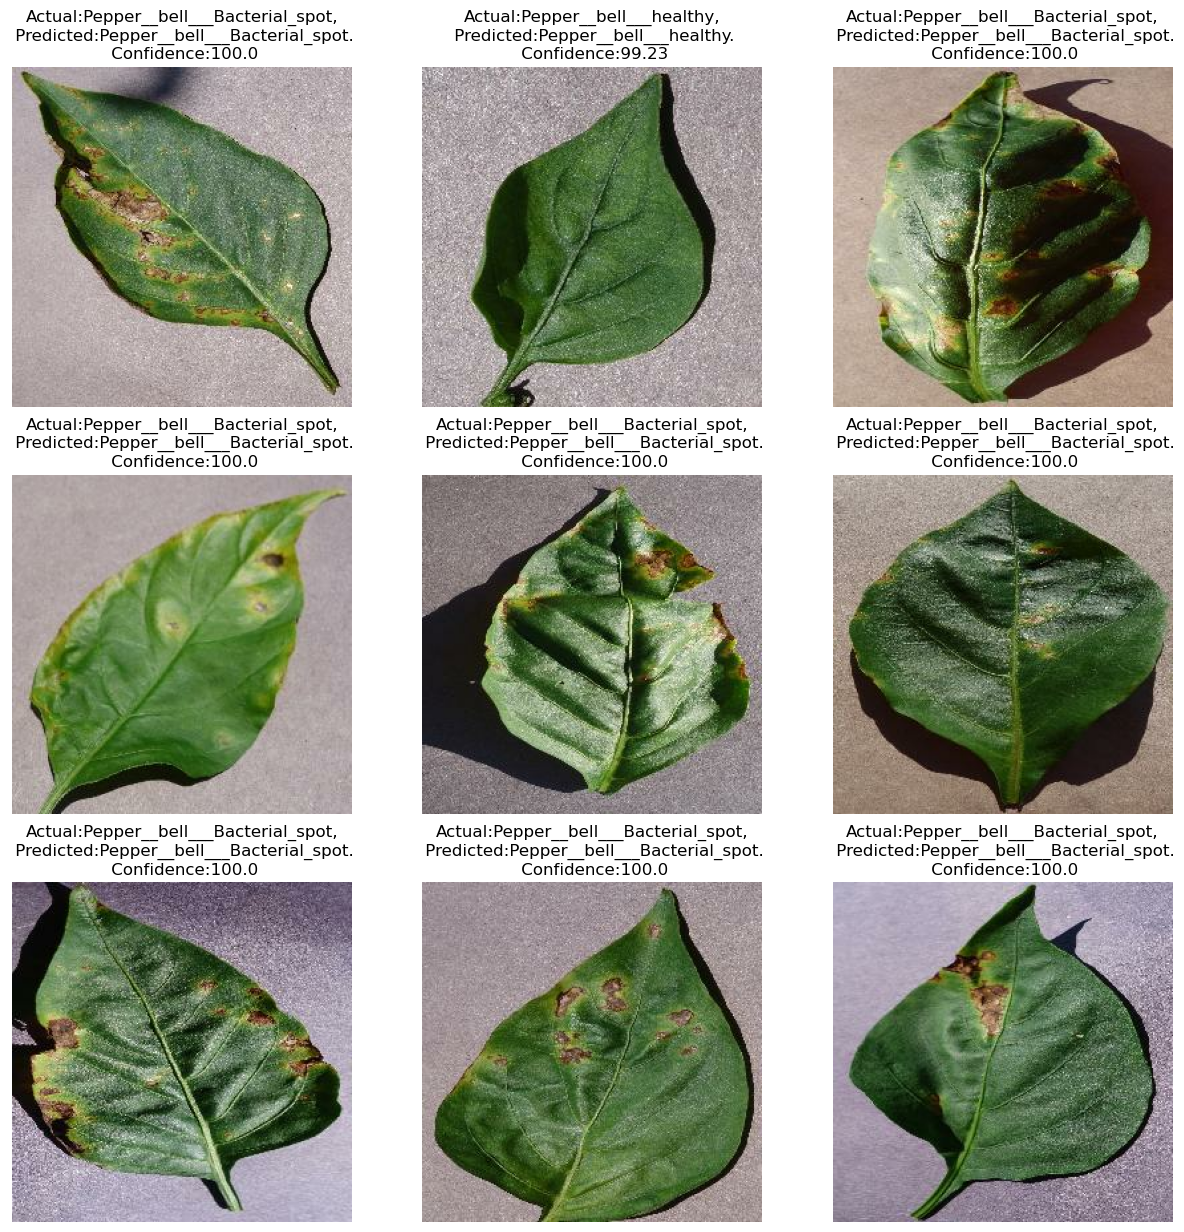

In [77]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(i):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}")
        plt.axis('off')
        plt.show

In [80]:
model_version = 2
save_path = f"../models/{model_version}.keras"
model.save(save_path)
print(f"Model saved to {save_path}")

Model saved to ../models/2.keras
